In [1]:
from pathlib import Path
import os

import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from src.model_dino.tf_data import get_tf_data, RandomStandardization, GaussianBlur
from src.model_dino.models import DinoModel
from src.models.models import unet_model

In [2]:

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
h5_file = h5py.File("../data/processed/hdf5_2d/data_selected_slices.hdf5", "r")
clinical_df = pd.read_csv(
    "../data/clinical_info_with_lung_info.csv").set_index("patient_id")

In [3]:
ds = get_tf_data(h5_file, clinical_df, local_inpainting=False, n_channels=2)


In [4]:
for images in ds.batch(4).take(1).as_numpy_iterator():
    pass

In [5]:
images[0].shape

(4, 256, 256, 2)

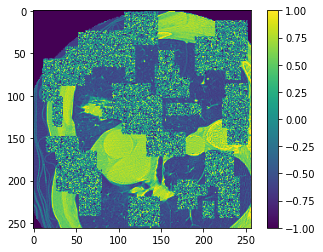

In [12]:
plt.imshow(images[2][0,:, :, 0])
plt.colorbar()

In [7]:
model_s = unet_model(10,
                     last_activation="softmax",
                     pretrained=False,
                     input_shape=(None, None, 2))
model_t = unet_model(10,
                     last_activation="softmax",
                     pretrained=False,
                     input_shape=(None, None, 2))


In [8]:
model = DinoModel(model_s, model_t)

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), run_eagerly=True)

In [10]:
model.fit(x=ds.batch(4).take(1))

1/1 [==============================] - 25s 25s/step
